<a id=top></a>
# STIS ACQ-FLUX Acquisition <a class="tocSkip">

<h1>Learning Goals<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span><ul class="toc-item"><li><span><a href="#Import-necessary-packages" data-toc-modified-id="Import-necessary-packages-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import necessary packages</a></span></li></ul></li><li><span><a href="#Define-Function-for-Plotting-Acquisition-Images-and-Performing-Target-Acquisition" data-toc-modified-id="Define-Function-for-Plotting-Acquisition-Images-and-Performing-Target-Acquisition-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Define Function for Plotting Acquisition Images and Performing Target Acquisition</a></span></li><li><span><a href="#Successful-Target-Acquisition" data-toc-modified-id="Successful-Target-Acquisition-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Successful Target Acquisition</a></span></li><li><span><a href="#Target-Acquisition-Failure-Cases" data-toc-modified-id="Target-Acquisition-Failure-Cases-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Target Acquisition Failure Cases</a></span><ul class="toc-item"><li><span><a href="#Exopsures-not-Performed" data-toc-modified-id="Exopsures-not-Performed-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Exopsures not Performed</a></span></li><li><span><a href="#Fine-Slew-Larger-then-4-Pixels" data-toc-modified-id="Fine-Slew-Larger-then-4-Pixels-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Fine Slew Larger then 4 Pixels</a></span></li><li><span><a href="#Ratio-of-Flux-in-Max-Checkbox-in-Fine-&amp;-Coarse-Stages-Greater-than-25%" data-toc-modified-id="Ratio-of-Flux-in-Max-Checkbox-in-Fine-&amp;-Coarse-Stages-Greater-than-25%-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Ratio of Flux in Max Checkbox in Fine &amp; Coarse Stages Greater than 25%</a></span></li><li><span><a href="#Lamp-not-illuminated" data-toc-modified-id="Lamp-not-illuminated-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Lamp not illuminated</a></span></li><li><span><a href="#Saturation-of-Pixels" data-toc-modified-id="Saturation-of-Pixels-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Saturation of Pixels</a></span></li></ul></li></ul></div>

## Introduction
There are two types of STIS target acquisition: ACQ and ACQ/PEAK. In this notebook, we will go through the steps for ACQ observations, and explore some success and failure cases.


For ACQ observations, the target acquisition data has three science extensions:
- Before Coarse Slew
- Before Fine Slew
- 0.2$\times$0.2 Reference Aperture with HITM lamp

The first science extension (Coarse Phase) of the acquisition raw file is an image of target in the target acquisition sub-array based on initial pointing. Then the coarse centering is performed: the software determines the position of the target with a flux weighted poiting algorithm, and calculates the slew needed to place the target at a reference point in the target acquisition sub-array; the coarse centered image is stored in the second science extension (Fine Phase). The next step is to perform fine centering: a 32 $\times$ 32 pixel image of the reference aperture is obtained and stored in the third science extension (Reference Aperture), the location of the aperture on the detector is determined, and a fine slew is performed to center the taret in the reference aperture (to place the object precisely in a slit).

For more information on ACQ target acquisition, see [`Evaluating Target Acquisitions and Guiding`](https://hst-docs.stsci.edu/stisdhb/chapter-5-stis-data-analysis/5-2-evaluating-target-acquisitions-and-guiding).

### Import necessary packages

**We will import the following packages:**

- `astropy.io fits` for accessing FITS files
- `astroquery.mast Observations` for finding and downloading data from the [MAST](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html) archive
- `pathlib`,`os` for managing system paths
- `matplotlib` for plotting data
- `stistools` for quick operations on STIS Data

In [1]:
# Import for: Reading in fits file
from astropy.io import fits

# Import for: Downloading necessary files. (Not necessary if you choose to collect data from MAST)
from astroquery.mast import Observations

# Import for: Managing system variables and paths
from pathlib import Path
import os

# Import for: Plotting and specifying plotting parameters
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
from astropy.visualization import ZScaleInterval
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.cmap'] = 'viridis'
matplotlib.rcParams['image.interpolation'] = 'none'
matplotlib.rcParams['figure.figsize'] = (20,7)

# Import for operations on STIS Data
import stistools

/Users/kding/miniconda3/envs/stis/lib/python3.7/site-packages/stsci/tools/nmpfit.py:8: UserWarning: NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.
  warnings.warn("NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.")
/Users/kding/miniconda3/envs/stis/lib/python3.7/site-packages/stsci/tools/gfit.py:18: UserWarning: GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it.Use astropy.modeling instead.
  warnings.warn("GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it."


The following tasks in the stistools package can be run with TEAL:
   basic2d      calstis     ocrreject     wavecal        x1d          x2d


## Define Function for Plotting Acquisition Images and Performing Target Acquisition

We define a function to plot the three science image extensions mentioned above, and run the stistools_tastis target acquisition method to show the result and associated information of target acquisition.

In [2]:
def acq(obs_id):
    # Search target objscy by obs_id
    target = Observations.query_criteria(obs_id=obs_id)
    # get a list of files assiciated with that target
    acq_list = Observations.get_product_list(target)
    # Download only the _raw and _spt fits files
    Observations.download_products(acq_list,extension=['raw.fits','spt.fits'])
    raw = os.path.join("./mastDownload/HST","{}".format(obs_id),"{}_raw.fits".format(obs_id))
    
    # plot the acquisition raw images
    with fits.open(raw) as hdu:
        initial = hdu[1].data
        confirm = hdu[4].data
        lamp = hdu[7].data
    zscaler = ZScaleInterval(contrast=0.10).get_limits 
    _, initial_max = zscaler(initial)
    _, confirm_max = zscaler(confirm)
    vmax = max(initial_max,confirm_max)
    
    # plot the initial target position in coarse phase
    TARGA1_1 = fits.getheader(raw,1)["TARGA1"]
    TARGA2_1 = fits.getheader(raw,1)["TARGA2"]
    TARGA1_2 = fits.getheader(raw,4)["TARGA1"]
    TARGA2_2 = fits.getheader(raw,4)["TARGA2"]
    centera1 = fits.getheader(raw,0)["CENTERA1"]
    centera2 = fits.getheader(raw,0)["CENTERA2"]
    sizaxis1 = fits.getheader(raw,0)["sizaxis1"]
    sizaxis2 = fits.getheader(raw,0)["sizaxis2"]
    corner1 = centera1 - sizaxis1/2 
    corner2 = centera2 - sizaxis2/2
    
    checkbox_size = fits.getheader(raw,0)["CHECKBOX"]
    
    
    plt.subplot(1,3,1)
    plt.imshow(initial,vmin = 0,vmax = vmax)
    plt.plot([TARGA1_1-corner1+1],[TARGA2_1-corner2+1],"rx")
    plt.title("Before Coarse Slew")
    plt.subplot(1,3,2)
    plt.imshow(confirm,vmin = 0,vmax = vmax)
    plt.plot([TARGA1_2-corner1+1],[TARGA2_2-corner2+1],"rx")
    plt.title("Before Fine Slew")
    plt.subplot(1,3,3)
    plt.imshow(lamp,vmin = 0,vmax = vmax)
    plt.title(r"$0.2 \times 0.2 Reference Aperture with HITM lamp$")
    plt.tight_layout()
    
    stistools.tastis.tastis(raw)

## Successful Target Acquisition
Here we present a successful target acquisition case in which the target is correctly selected from the initial pointing image, coarse centering and fine centering are successfully performed, and the target is eventually centered in the slit. The target location, coarse slew, and fine slew data are printed by stistools.tastis. Note here that the coordinate system of tastis is 1-indexed while Python is 0-indexed.

INFO: Found cached file ./mastDownload/HST/octka2daq/octka2daq_spt.fits with expected size 155520. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/octka2daq/octka2daq_raw.fits with expected size 120960. [astroquery.query]
octka2daq       HST/STIS    MIRVIS      F25ND3             ACQ/POINT
prop: 14161      visit: A2    line: 1   target: HD-84937
obs date, time: 2016-04-30    10:09:43   exposure time:  2.10
dom GS/FGS: N6U6000023F2    sub-dom GS/FGS: N6U7000178F1
ACQ params:     bias sub: 1510   checkbox: 3      method: FLUX CENTROID
subarray (axis1,axis2):   size=(100,100)          corner=(487,466)
-------------------------------------------------------------------------------
Coarse locate phase:           Target flux in max checkbox (DN): 3194

                       global          local
                    axis1 axis2     axis1 axis2
Target location:    531.9  516.2    45.9  51.2

                    axis1 axis2     axis1  axis2         V2      V3
                    

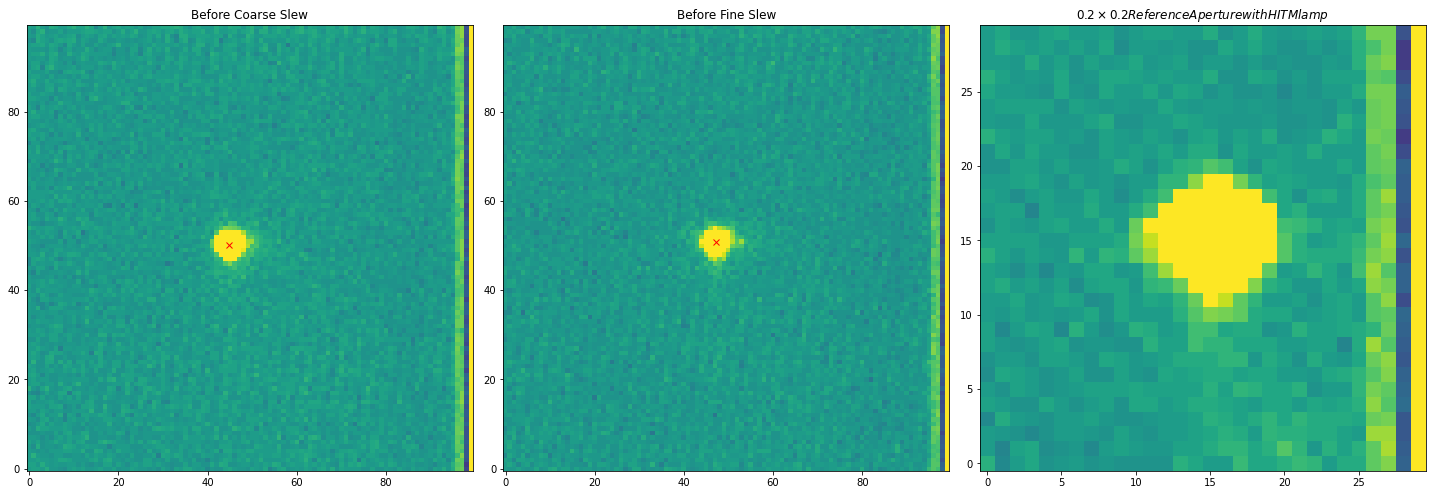

In [3]:
acq("octka2daq")

## Target Acquisition Failure Cases
In this section, we will go through several typical cases of acquisition failure. 

**Notice that sometimes a single failure case might be caused by multiple acquisition warnings, as printed by tastis.**

### Exopsures not Performed
As indicated by telemetry, the intended exposures were not performed, and thus there is not a clear bright source in the Before Coarse Slew and Before Fine Slew images. In this specific case, the shutter opened for a brief part of the fine slew exposure, which leads to the faint glow in the Before Fine Slew image. Usually,exposure failures can also cause other issues such as fine slew larger than 4 pixels or Ratio of Flux in Max Checkbox in Fine & Coarse Stages Greater than 25%, because the tastis algorithm cannot pick up the proper bright source in the image to perform the following steps of acquisition.

INFO: Found cached file ./mastDownload/HST/oehu53fzq/oehu53fzq_spt.fits with expected size 155520. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/oehu53fzq/oehu53fzq_raw.fits with expected size 120960. [astroquery.query]
oehu53fzq       HST/STIS    MIRVIS     F28X50LP             ACQ/POINT
prop: 16449      visit: 53    line: 1   target: V-EG-UMA
obs date, time: 2021-04-26    19:26:43   exposure time:  1.64
dom GS/FGS: N46D000093F1    sub-dom GS/FGS: N46D000163F2
ACQ params:     bias sub: 1536   checkbox: 3      method: FLUX CENTROID
subarray (axis1,axis2):   size=(100,100)          corner=(487,466)
-------------------------------------------------------------------------------
Coarse locate phase:           Target flux in max checkbox (DN): 96

                       global          local
                    axis1 axis2     axis1 axis2
Target location:    530.0  560.0    44.0  95.0

                    axis1 axis2     axis1  axis2         V2      V3
                     

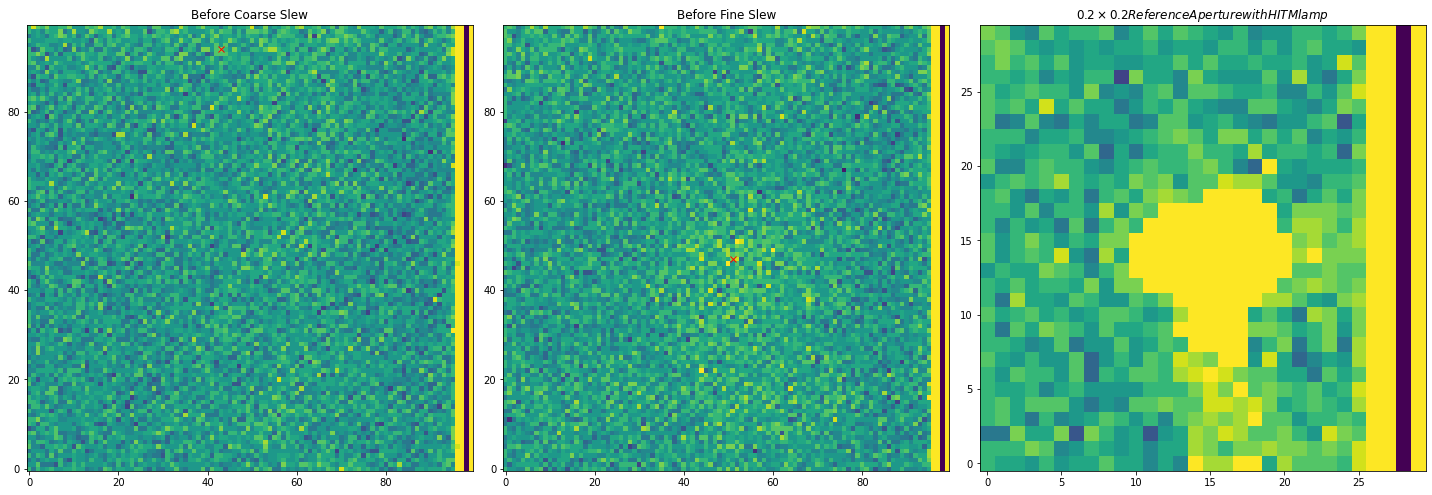

In [10]:
acq("oehu53fzq")

### Fine Slew Larger then 4 Pixels
In this example, there isn't an obvious bright object in the initial pointing image. And thus the coarse and fine slew selects the brightest region in each phases, which do not correspond to the actual target of this acquisiton. Since there is a large different between the slew pixels, tastis concludes as problem with the acquisition.

INFO: Found cached file ./mastDownload/HST/ocw901lyq/ocw901lyq_spt.fits with expected size 155520. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/ocw901lyq/ocw901lyq_raw.fits with expected size 120960. [astroquery.query]
ocw901lyq       HST/STIS    MIRVIS     F28X50LP             ACQ/POINT
prop: 14211      visit: 01    line: 1   target: MQ1-OFFSET
obs date, time: 2016-07-05    01:52:45   exposure time: 240.10
dom GS/FGS: S96T000284F2    sub-dom GS/FGS: S96T000160F1
ACQ params:     bias sub: 1510   checkbox: 3      method: FLUX CENTROID
subarray (axis1,axis2):   size=(100,100)          corner=(487,466)
-------------------------------------------------------------------------------
Coarse locate phase:           Target flux in max checkbox (DN): 1442

                       global          local
                    axis1 axis2     axis1 axis2
Target location:    488.0  504.0     2.0  39.0

                    axis1 axis2     axis1  axis2         V2      V3
                

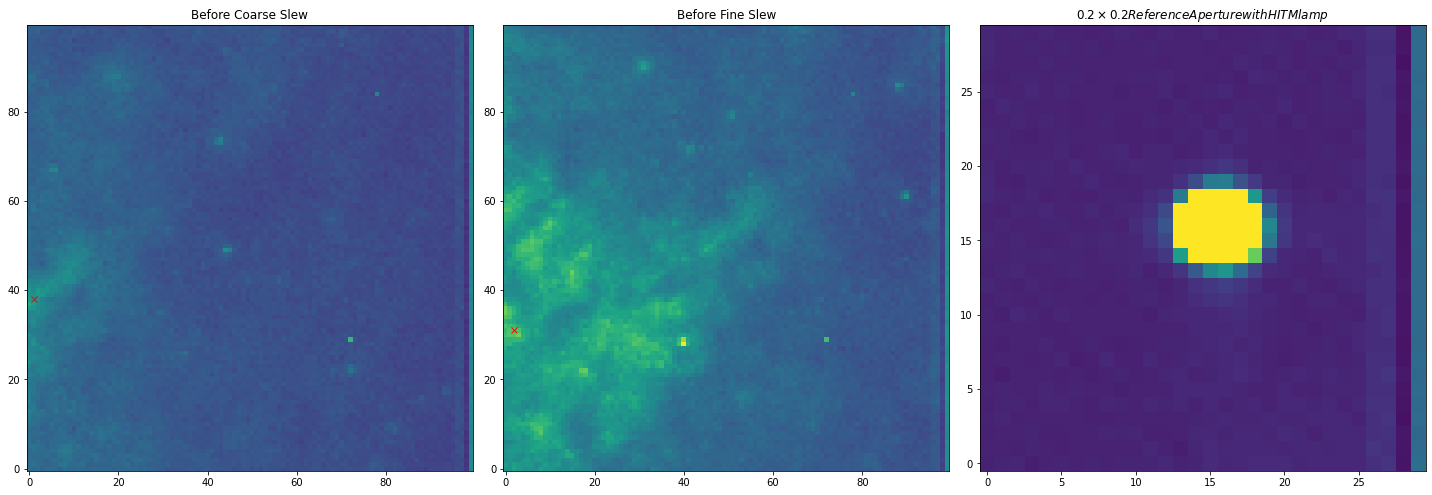

In [5]:
acq("ocw901lyq")

### Ratio of Flux in Max Checkbox in Fine & Coarse Stages Greater than 25%
In the coarse phase and fine phase, max checkboxes selected at the brightest source in the image, and the target flux in the max checkboxes is calculated respectively. A warning is generated if the ratio of target fluxes in max checkbox is greater than 25%. In this example, the intended exposure failed in the coarse phase, which leads to the large gap of flux in max checkbox between coarse and fine phases.

INFO: Found cached file ./mastDownload/HST/oe1l55vjq/oe1l55vjq_spt.fits with expected size 155520. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/oe1l55vjq/oe1l55vjq_raw.fits with expected size 120960. [astroquery.query]
oe1l55vjq       HST/STIS    MIRVIS      F25ND5             ACQ/POINT
prop: 15905      visit: 55    line: 1   target: FOMALHAUT2
obs date, time: 2021-08-20    08:11:54   exposure time:  2.87
dom GS/FGS: SBKK000020F3    sub-dom GS/FGS: SBLC000216F2
ACQ params:     bias sub: 1536   checkbox: 3      method: FLUX CENTROID
subarray (axis1,axis2):   size=(100,100)          corner=(487,466)
-------------------------------------------------------------------------------
Coarse locate phase:           Target flux in max checkbox (DN): 106

                       global          local
                    axis1 axis2     axis1 axis2
Target location:    541.0  516.9    55.0  51.9

                    axis1 axis2     axis1  axis2         V2      V3
                   

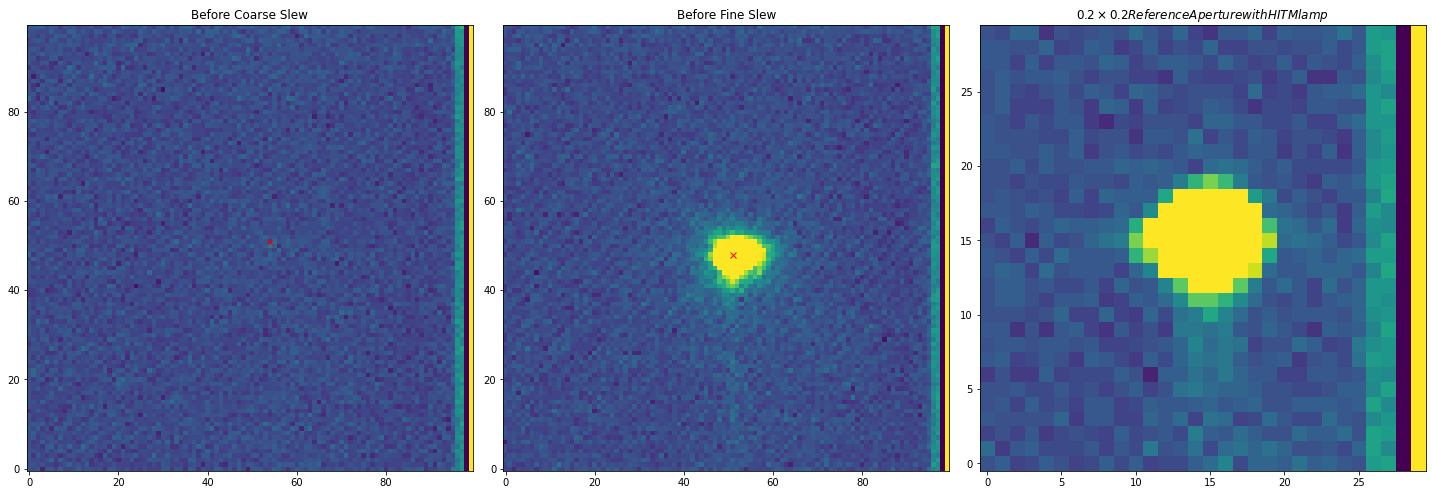

In [6]:
acq("oe1l55vjq")

### Lamp not illuminated
As shown in the reference aperture, this example has the issue that the reference aperture HITM lamp has a flux smaller than the typical minumun value for the lamp, which means the lamp might not be illuminated properly.

INFO: Found cached file ./mastDownload/HST/oeds03rzq/oeds03rzq_spt.fits with expected size 155520. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/oeds03rzq/oeds03rzq_raw.fits with expected size 120960. [astroquery.query]
oeds03rzq       HST/STIS    MIRVIS     F28X50LP             ACQ/POINT
prop: 16218      visit: 03    line: 1   target: 47TUC-OFFSET1
obs date, time: 2022-02-24    05:53:24   exposure time:  2.27
dom GS/FGS: S0W5000538F2    sub-dom GS/FGS: S0WC000284F1
ACQ params:     bias sub: 1536   checkbox: 3      method: FLUX CENTROID
subarray (axis1,axis2):   size=(100,100)          corner=(487,466)
-------------------------------------------------------------------------------
Coarse locate phase:           Target flux in max checkbox (DN): 106

                       global          local
                    axis1 axis2     axis1 axis2
Target location:    533.0  564.0    47.0  99.0

                    axis1 axis2     axis1  axis2         V2      V3
               

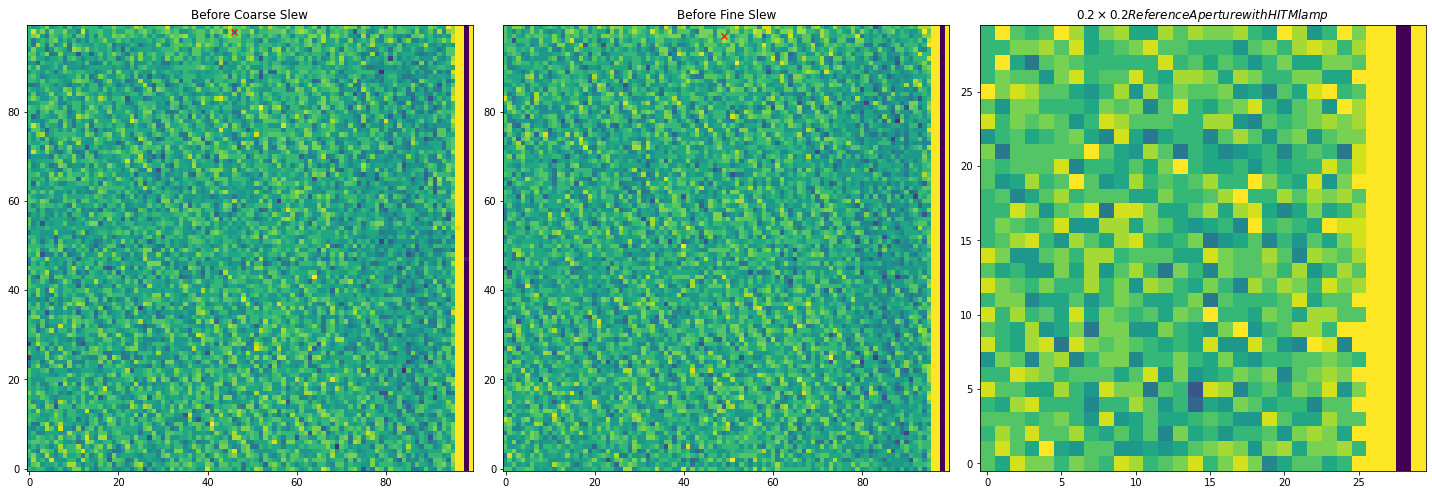

In [7]:
acq("oeds03rzq")

### Saturation of Pixels

oe4h03rdq       HST/STIS    MIRVIS     F28X50LP             ACQ/POINT
prop: 15836      visit: 03    line: 1   target: V-AU-MIC-1
obs date, time: 2020-07-03    00:20:25   exposure time:  0.50
dom GS/FGS: SCLW000169F1    sub-dom GS/FGS: SCLW000085F2
ACQ params:     bias sub: 1536   checkbox: 3      method: FLUX CENTROID
subarray (axis1,axis2):   size=(100,100)          corner=(487,466)
-------------------------------------------------------------------------------
Coarse locate phase:           Target flux in max checkbox (DN): 233847

                       global          local
                    axis1 axis2     axis1 axis2
Target location:    534.8  513.0    48.8  48.0

                    axis1 axis2     axis1  axis2         V2      V3
                      (pixels)        (arcsec)            (arcsec)
Estimated slew:     -0.9  -3.0    -0.047 -0.152       -0.141  0.074
-------------------------------------------------------------------------------
Fine locate phase:            Target

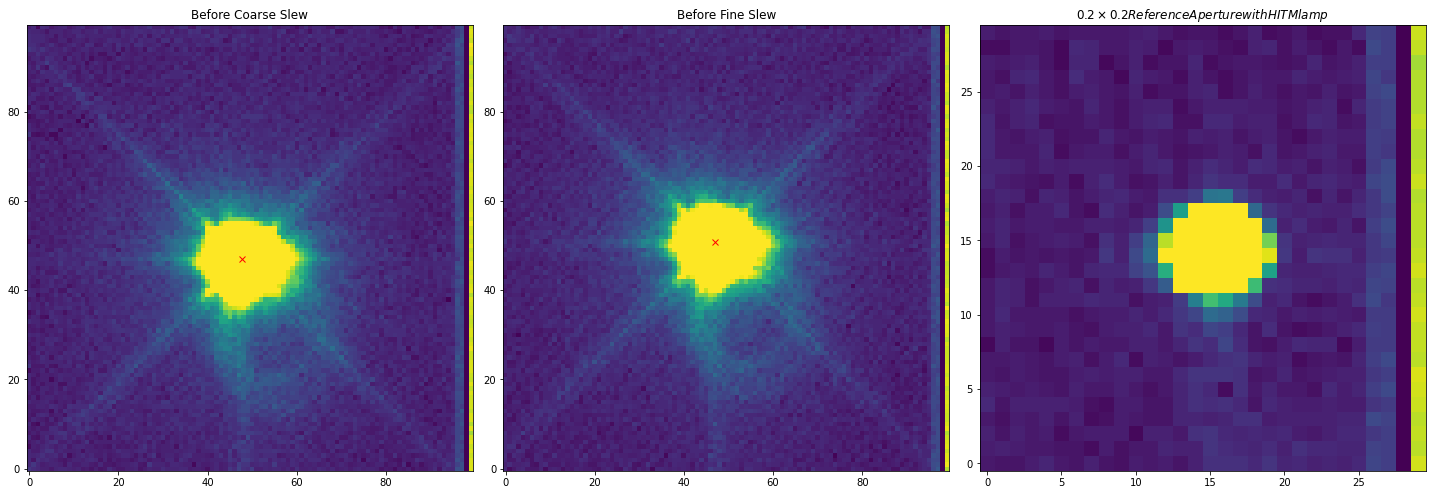

In [9]:
acq("oe4h03rdq")


---
## About this Notebook <a class="tocSkip">
**Author:** [Keyi Ding](kding@stsci.edu)

**Updated On:** 2022-11-1


> *This tutorial was generated to be in compliance with the [STScI style guides](https://github.com/spacetelescope/style-guides) and would like to cite the [Jupyter guide](https://github.com/spacetelescope/style-guides/blob/master/templates/example_notebook.ipynb) in particular.*
## Citations <a class="tocSkip">

If you use `astropy`, `matplotlib`, `astroquery`, or `numpy` for published research, please cite the
authors. Follow these links for more information about citations:

* [Citing `astropy`/`numpy`/`matplotlib`](https://www.scipy.org/citing.html)
* [Citing `astroquery`](https://astroquery.readthedocs.io/en/latest/)

---

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 